# Sunitha Nagrath Lab (notebook 2)

### Code credits: Yuru Chen, Touma Yoneyama

In [1]:
%pip install pandas numpy tensorflow scikit-learn matplotlib seaborn joblib spicy

Note: you may need to restart the kernel to use updated packages.


In [2]:
# c&p from notebook 1

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from scipy.stats import norm, probplot

2024-11-18 12:03:07.175527: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-18 12:03:07.394567: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-18 12:03:07.604402: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-18 12:03:07.764224: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-18 12:03:07.800407: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 12:03:08.036755: I tensorflow/core/platform/cpu_feature_gu

# 1. Merge and Adjust Data Sets

## Adjust EM Files

In [3]:
# Adjust EM_files

# Load the CSV files
EM_memb = pd.read_csv('fixed_old_datasets/E_memb.csv')
EM_nuclei = pd.read_csv('fixed_old_datasets/E.csv')

# Drop rows where "Annotation" is empty
EM_memb = EM_memb.dropna(subset=['Annotation'])
EM_nuclei = EM_nuclei.dropna(subset=['Annotation'])

# Concatinate "Memb." to column names beyond "Annotation" for EM_memb
EM_memb.columns = list(EM_memb.columns[:3]) + ['Memb.' + col for col in EM_memb.columns[3:]]

# Concatinate "Nuclei." to column names beyond "Annotation" for EM_nuc
EM_nuclei.columns = list(EM_nuclei.columns[:4]) + ['Nue.' + col for col in EM_nuclei.columns[4:]]

# Merge EM_memb and EM_nuclei on "ObjectNumber" and "Annotation"
EM = pd.merge(EM_memb, EM_nuclei, on=['ObjectNumber', 'Annotation'])

# Replace "ImageNumber_x" column name with "BaseFile". Fill value
EM = EM.rename(columns={'ImageNumber_x': 'BaseFile'})
EM['BaseFile'] = 'EM_file'
EM.drop(columns=['Cell_objectnumber'], inplace=True)

# Print head
print(EM.head())

  BaseFile  ObjectNumber Annotation  Memb.AreaShape_Area  \
0  EM_file             3          E                 5270   
1  EM_file             3          E                 5270   
2  EM_file             3          E                 5270   
3  EM_file             4          E                 5093   
4  EM_file             5          E                 7616   

   Memb.AreaShape_BoundingBoxArea  Memb.AreaShape_BoundingBoxMaximum_X  \
0                            8774                                 1277   
1                            8774                                 1277   
2                            8774                                 1277   
3                            8010                                 1180   
4                           13420                                 1190   

   Memb.AreaShape_BoundingBoxMaximum_Y  Memb.AreaShape_BoundingBoxMinimum_X  \
0                                  310                                 1170   
1                                  3

## Adjust M Files

In [4]:
# Adjust M_files

# Load the CSV files
M_memb = pd.read_csv('fixed_old_datasets/MyExpt_FilteredCells_with_annotation_additional_corresponding_cell.csv')
M_nuclei = pd.read_csv('fixed_old_datasets/MyExpt_FilteredNuclei_nei_annotated_additional_corresponding_cell.csv')

# For M_memb, replace the third column name with "Annotation"
M_memb.columns = list(M_memb.columns[:2]) + ['Annotation'] + list(M_memb.columns[3:])

# Drop rows where "Annotation" is empty
M_memb = M_memb.dropna(subset=['Annotation'])
M_nuclei = M_nuclei.dropna(subset=['Annotation'])

# Concatinate "Memb." to column names beyond "Annotation" for EM_memb
M_memb.columns = list(M_memb.columns[:3]) + ['Memb.' + col for col in M_memb.columns[3:]]

# Concatinate "Nuclei." to column names beyond "Annotation" for EM_nuc
M_nuclei.columns = list(M_nuclei.columns[:4]) + ['Nue.' + col for col in M_nuclei.columns[4:]]

# Merge EM_memb and EM_nuclei on "ObjectNumber" and "Annotation"
M = pd.merge(M_memb, M_nuclei, on=['ObjectNumber', 'Annotation'])

# Replace "ImageNumber_x" column name with "BaseFile". Fill value
M = M.rename(columns={'ImageNumber_x': 'BaseFile'})
M['BaseFile'] = 'M_file'
M.drop(columns=['Cell_objectnumber'], inplace=True)

# Print head
print(M.head())

  BaseFile  ObjectNumber Annotation  Memb.AreaShape_Area  \
0   M_file             1          M                 4198   
1   M_file             1          M                 4198   
2   M_file             3          M                 4945   
3   M_file             3          M                 4945   
4   M_file             4          M                 6059   

   Memb.AreaShape_BoundingBoxArea  Memb.AreaShape_BoundingBoxMaximum_X  \
0                           10787                                  949   
1                           10787                                  949   
2                           11600                                 1277   
3                           11600                                 1277   
4                           14429                                 2237   

   Memb.AreaShape_BoundingBoxMaximum_Y  Memb.AreaShape_BoundingBoxMinimum_X  \
0                                  222                                  882   
1                                  2

# Merge

In [5]:
# Merge EM and M

# 合并数据
final_combined_data1 = pd.concat([M, EM], ignore_index=True)

# 查看合并后的数据
print(final_combined_data1)

# 保存合并后的数据
final_combined_data1.to_csv('111524final_combined_data1.csv', index=False)


    BaseFile  ObjectNumber Annotation  Memb.AreaShape_Area  \
0     M_file             1          M                 4198   
1     M_file             1          M                 4198   
2     M_file             3          M                 4945   
3     M_file             3          M                 4945   
4     M_file             4          M                 6059   
..       ...           ...        ...                  ...   
219  EM_file            17          M                 5135   
220  EM_file            18          M                 3688   
221  EM_file            21          M                 7505   
222  EM_file            21          M                 7505   
223  EM_file            26          M                 3158   

     Memb.AreaShape_BoundingBoxArea  Memb.AreaShape_BoundingBoxMaximum_X  \
0                             10787                                  949   
1                             10787                                  949   
2                          

# 2. PCA and PL-SDA on Data1 and Apply it to Data2 (Combined_Data.csv)

## Fit PCA

### X_old_scaled

In [6]:
# Prepare features
X_old = final_combined_data1.drop(columns=['ObjectNumber', 'Annotation', 'BaseFile'])

# Drop nan columns "_NormalizedMoment_0_0", "_NormalizedMoment_1_0", and "_NormalizedMoment_0_1" since it only contains NaN values
nan_columns = ['Memb.AreaShape_NormalizedMoment_0_0',
               'Memb.AreaShape_NormalizedMoment_0_1',
               'Memb.AreaShape_NormalizedMoment_1_0',
               'Nue.AreaShape_NormalizedMoment_0_0',
               'Nue.AreaShape_NormalizedMoment_0_1',
               'Nue.AreaShape_NormalizedMoment_1_0']
columns_to_drop = [col for col in nan_columns if col in X_old.columns]
X_old = X_old.drop(columns=columns_to_drop)

# Drop other unecessary columns
# Mean_Cells_Location_Center_X, Mean_Cells_Location_Center_Y, 
# Mean_Cells_Location_Center_Z, Mean_Cells_Number_Object_Number, 
# Number_Object_Number, Parent_Nuclei, AreaShape_BoundingBoxMaximum_X, 
# AreaShape_BoundingBoxMaximum_Y, AreaShape_BoundingBoxMinimum_X, 
# AreaShape_BoundingBoxMinimum_Y, AreaShape_Center_X, AreaShape_Center_Y, 
# Children_Cells_Count, Location_Center_Z, Location_Center_X, Location_Center_Y
unecessary_columns = ['Memb.Mean_Cells_Location_Center_X', 
                      'Memb.Mean_Cells_Location_Center_Y', 
                      'Memb.Mean_Cells_Location_Center_Z',
                      'Memb.Mean_Cells_Number_Object_Number', 
                      'Memb.Number_Object_Number', 
                      'Memb.Parent_Nuclei', 
                      'Memb.AreaShape_BoundingBoxMaximum_X',
                      'Memb.AreaShape_BoundingBoxMaximum_Y',
                      'Memb.AreaShape_BoundingBoxMinimum_X',
                      'Memb.AreaShape_BoundingBoxMinimum_Y',
                      'Memb.AreaShape_Center_X',
                      'Memb.AreaShape_Center_Y',
                      'Memb.Children_Cells_Count',
                      'Memb.Location_Center_Z',
                      'Memb.Location_Center_X',
                      'Memb.Location_Center_Y',
                      'Nue.Mean_Cells_Location_Center_X', 
                      'Nue.Mean_Cells_Location_Center_Y', 
                      'Nue.Mean_Cells_Location_Center_Z',
                      'Nue.Mean_Cells_Number_Object_Number', 
                      'Nue.Number_Object_Number', 
                      'Nue.Parent_Nuclei', 
                      'Nue.AreaShape_BoundingBoxMaximum_X',
                      'Nue.AreaShape_BoundingBoxMaximum_Y',
                      'Nue.AreaShape_BoundingBoxMinimum_X',
                      'Nue.AreaShape_BoundingBoxMinimum_Y',
                      'Nue.AreaShape_Center_X',
                      'Nue.AreaShape_Center_Y',
                      'Nue.Children_Cells_Count',
                      'Nue.Location_Center_Z',
                      'Nue.Location_Center_X',
                      'Nue.Location_Center_Y',]
columns_to_drop = [col for col in unecessary_columns if col in X_old.columns]
X_old = X_old.drop(columns=columns_to_drop)

# Drop columns that doesnt exist in new data
unmatching_columns = ['ImageNumber_y', 
                      'Nue.Mean_Cells_Distance_Centroid_FilteredNuclei_nei'] 
columns_to_drop = [col for col in unmatching_columns if col in X_old.columns]
X_old = X_old.drop(columns=columns_to_drop)

# Save X_old
X_old.to_csv('111524X_old.csv', index=False)

# Scalar
scaler = StandardScaler()
X_old_scaled = scaler.fit_transform(X_old)

# Save scalar
joblib.dump(scaler, '111524scaler_old_data.pkl')

['111524scaler_old_data.pkl']

In [7]:
# PCA (Principal Component Analysis) is a dimensionality reduction technique 
# that transforms the data into a new coordinate system, where the axes 
# (principal components) correspond to directions of maximum variance in the data.

# create PCA model
pca = PCA(n_components=2)
X_old_pca = pca.fit_transform(X_old_scaled)

# X_pca would have a shape of (n_samples, n_components)
print("n_samples = ", X_old_scaled.shape[0])
print("X_pca shape: ", X_old_pca.shape)

# y = annotation
y = final_combined_data1['Annotation'].values

# Print out explained variance ratio
print("Explained variance ratio: ", pca.explained_variance_ratio_)

n_samples =  224
X_pca shape:  (224, 2)
Explained variance ratio:  [0.21675604 0.09169565]


### Print C1

In [8]:
# Access PC1 loadings
pc1_loadings = pca.components_[0]
# Combine with feature names for readability
X_old_df = pd.DataFrame(X_old)
pc1_features = pd.DataFrame({'Feature': X_old_df.columns, 'PC1 Loading': pc1_loadings})
pc1_features = pc1_features.sort_values(by='PC1 Loading', ascending=False)
# Print
print(pc1_features)
# Save
pc1_features.to_csv('111524pc1_features.csv', index=False)

                             Feature  PC1 Loading
35   Memb.AreaShape_MaxFeretDiameter     0.136378
34    Memb.AreaShape_MajorAxisLength     0.135164
14        Memb.AreaShape_Compactness     0.129918
135   Nue.AreaShape_MaxFeretDiameter     0.129114
134    Nue.AreaShape_MajorAxisLength     0.128574
..                               ...          ...
69        Memb.AreaShape_Zernike_0_0    -0.119915
120         Nue.AreaShape_FormFactor    -0.120521
169        Nue.AreaShape_Zernike_0_0    -0.123130
20         Memb.AreaShape_FormFactor    -0.123387
71        Memb.AreaShape_Zernike_2_0    -0.125332

[199 rows x 2 columns]


## Plot

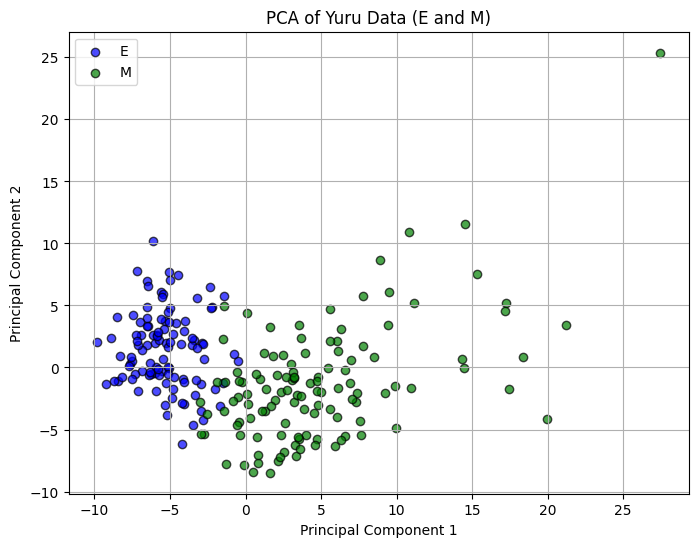

In [9]:
# plot the PCA results
plt.figure(figsize=(8, 6))
plt.scatter(X_old_pca[y == 'E', 0], X_old_pca[y == 'E', 1], c='blue', label='E', alpha=0.7, edgecolor='k')
plt.scatter(X_old_pca[y == 'M', 0], X_old_pca[y == 'M', 1], c='green', label='M', alpha=0.7, edgecolor='k')
plt.title('PCA of Yuru Data (E and M)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()
# save plot
plt.savefig("Metrics/pca_on_data1.png", format='png', bbox_inches='tight')
plt.close()

## Apply PCA Space to New Data

### X_new_scaled

In [10]:
# Load new data from Combined_Data.csv
final_combined_data2 = pd.read_csv('Combined_Data.csv')

# Prepare features
X_new = final_combined_data2.drop(columns=['ImageNumber', 'ObjectNumber', 'Annotation'])

# Drop columns "_NormalizedMoment_0_0", "_NormalizedMoment_1_0", and "_NormalizedMoment_0_1" since it only contains NaN values
nan_columns = ['Memb.AreaShape_NormalizedMoment_0_0',
               'Memb.AreaShape_NormalizedMoment_0_1',
               'Memb.AreaShape_NormalizedMoment_1_0',
               'Nue.AreaShape_NormalizedMoment_0_0',
               'Nue.AreaShape_NormalizedMoment_0_1',
               'Nue.AreaShape_NormalizedMoment_1_0']
columns_to_drop = [col for col in nan_columns if col in X_new.columns]
X_new = X_new.drop(columns=columns_to_drop)

# Drop other unecessary columns
# Mean_Cells_Location_Center_X, Mean_Cells_Location_Center_Y, 
# Mean_Cells_Location_Center_Z, Mean_Cells_Number_Object_Number, 
# Number_Object_Number, Parent_Nuclei, AreaShape_BoundingBoxMaximum_X, 
# AreaShape_BoundingBoxMaximum_Y, AreaShape_BoundingBoxMinimum_X, 
# AreaShape_BoundingBoxMinimum_Y, AreaShape_Center_X, AreaShape_Center_Y, 
# Children_Cells_Count, Location_Center_Z, Location_Center_X, Location_Center_Y
unecessary_columns = ['Memb.Mean_Cells_Location_Center_X', 
                      'Memb.Mean_Cells_Location_Center_Y', 
                      'Memb.Mean_Cells_Location_Center_Z',
                      'Memb.Mean_Cells_Number_Object_Number', 
                      'Memb.Number_Object_Number', 
                      'Memb.Parent_Nuclei', 
                      'Memb.AreaShape_BoundingBoxMaximum_X',
                      'Memb.AreaShape_BoundingBoxMaximum_Y',
                      'Memb.AreaShape_BoundingBoxMinimum_X',
                      'Memb.AreaShape_BoundingBoxMinimum_Y',
                      'Memb.AreaShape_Center_X',
                      'Memb.AreaShape_Center_Y',
                      'Memb.Children_Cells_Count',
                      'Memb.Location_Center_Z',
                      'Memb.Location_Center_X',
                      'Memb.Location_Center_Y',
                      'Nue.Mean_Cells_Location_Center_X', 
                      'Nue.Mean_Cells_Location_Center_Y', 
                      'Nue.Mean_Cells_Location_Center_Z',
                      'Nue.Mean_Cells_Number_Object_Number', 
                      'Nue.Number_Object_Number', 
                      'Nue.Parent_Nuclei', 
                      'Nue.AreaShape_BoundingBoxMaximum_X',
                      'Nue.AreaShape_BoundingBoxMaximum_Y',
                      'Nue.AreaShape_BoundingBoxMinimum_X',
                      'Nue.AreaShape_BoundingBoxMinimum_Y',
                      'Nue.AreaShape_Center_X',
                      'Nue.AreaShape_Center_Y',
                      'Nue.Children_Cells_Count',
                      'Nue.Location_Center_Z',
                      'Nue.Location_Center_X',
                      'Nue.Location_Center_Y',]
columns_to_drop = [col for col in unecessary_columns if col in X_new.columns]
X_new = X_new.drop(columns=columns_to_drop)

# Drop columns that doesnt exist in new data
unmatching_columns = ['Memb.Children_FilteredNuclei__Count', 
                      'Memb.Mean_FilteredNuclei__Children_Cells_Count', 
                      'Memb.Mean_FilteredNuclei__Distance_Centroid_FilteredCells', 
                      'Memb.Mean_FilteredNuclei__Location_Center_X',
                      'Memb.Mean_FilteredNuclei__Location_Center_Y',
                      'Memb.Mean_FilteredNuclei__Location_Center_Z', 
                      'Memb.Mean_FilteredNuclei__Number_Object_Number', 
                      'index_y', 
                      'Nue.Parent_FilteredNuclei_'] 
columns_to_drop = [col for col in unmatching_columns if col in X_new.columns]
X_new = X_new.drop(columns=columns_to_drop)

# Save X_new
X_new.to_csv('111524X_new.csv', index=False)

# Scalar
scaler = StandardScaler()
X_new_scaled = scaler.fit_transform(X_new)

# Save scalar
joblib.dump(scaler, '111524scaler_new_data.pkl')

['111524scaler_new_data.pkl']

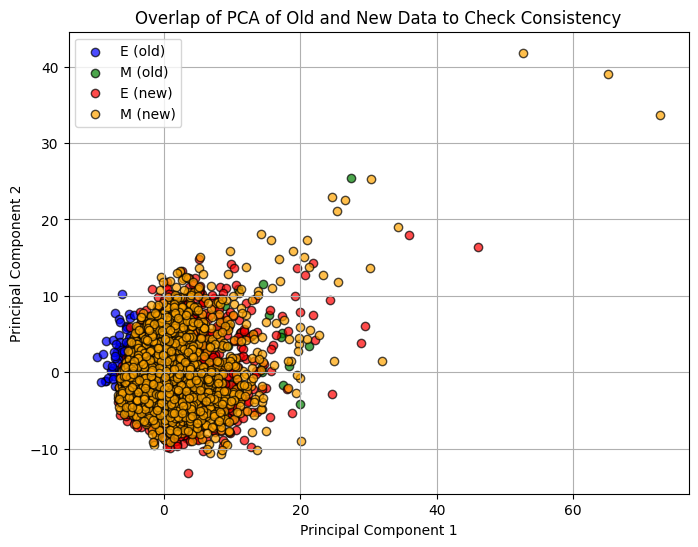

Plot Shows that the PCA space of New and Old data matches!


In [11]:
# Transform the old and new data using the fitted PCA
X_new_pca = pca.transform(X_new_scaled)  # New data projected into the old PCA space

# y = annotation
y_new = final_combined_data2['Annotation'].values

# Compare the PCA results of the old and new data
plt.figure(figsize=(8, 6))
plt.scatter(X_old_pca[y == 'E', 0], X_old_pca[y == 'E', 1], c='blue', label='E (old)', alpha=0.7, edgecolor='k')
plt.scatter(X_old_pca[y == 'M', 0], X_old_pca[y == 'M', 1], c='green', label='M (old)', alpha=0.7, edgecolor='k')
plt.scatter(X_new_pca[y_new == 'E', 0], X_new_pca[y_new == 'E', 1], c='red', label='E (new)', alpha=0.7, edgecolor='k')
plt.scatter(X_new_pca[y_new == 'M', 0], X_new_pca[y_new == 'M', 1], c='orange', label='M (new)', alpha=0.7, edgecolor='k')
plt.title('Overlap of PCA of Old and New Data to Check Consistency')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()
# save plot
plt.savefig("Metrics/compare_pca_old_and_pca_new.png", format='png', bbox_inches='tight')
plt.close()

print('Plot Shows that the PCA space of New and Old data matches!')

## Fit PLS-DA

In [12]:
# PLS-DA (Partial Least Squares Discriminant Analysis) is a supervised method
# that projects the data into a new coordinate system that maximizes the separation
# between classes. It is often used for classification tasks.

# basically a supervised version of PCA

# Encode the annotations to numerical values
le = LabelEncoder()
y_old = final_combined_data1['Annotation'].values
y_old_encoded = le.fit_transform(y_old)

# Create PLS-DA model
pls_da = PLSRegression(n_components=2)
X_old_pls_da = pls_da.fit_transform(X_old_scaled, y_old_encoded)[0]

# X_pls_da would have a shape of (n_samples, n_components)
print("n_samples = ", X_old_scaled.shape[0])
print("X_pls_da shape: ", X_old_pls_da.shape)

# Print out component weights
print("Component weights: ", pls_da.x_weights_)

n_samples =  224
X_pls_da shape:  (224, 2)
Component weights:  [[-3.04833265e-02 -9.37670699e-02]
 [-8.84885719e-02 -8.85258171e-02]
 [-3.04833265e-02 -9.37670699e-02]
 [-1.53532374e-02 -2.45266530e-02]
 [-6.34630172e-02 -7.46209720e-02]
 [-8.23941355e-03  6.11708982e-02]
 [-2.61722564e-03  9.77989810e-02]
 [ 2.14216959e-04  1.53832169e-02]
 [ 1.17149921e-02  2.73836409e-02]
 [ 7.86025288e-03  1.75608656e-02]
 [-6.61350105e-02 -1.03936530e-01]
 [ 3.25155694e-02  1.43970759e-01]
 [-5.47106969e-02 -1.40176166e-01]
 [ 1.31847183e-02  1.20834832e-01]
 [-1.30826303e-01 -1.01630756e-02]
 [-6.52629126e-02 -9.52453088e-02]
 [-1.29977068e-01  7.19712132e-02]
 [-2.79580236e-02 -9.21104613e-02]
 [-0.00000000e+00  0.00000000e+00]
 [ 1.45647564e-01 -8.31818388e-02]
 [ 1.54005015e-01 -8.50884935e-02]
 [-1.19287104e-01 -4.19924738e-02]
 [-7.50241285e-02 -1.08161401e-01]
 [-6.00101304e-02 -1.06426619e-01]
 [-5.51417332e-02 -1.10902563e-01]
 [-3.27066723e-02 -1.24883395e-01]
 [-4.04749757e-02 -1.334001

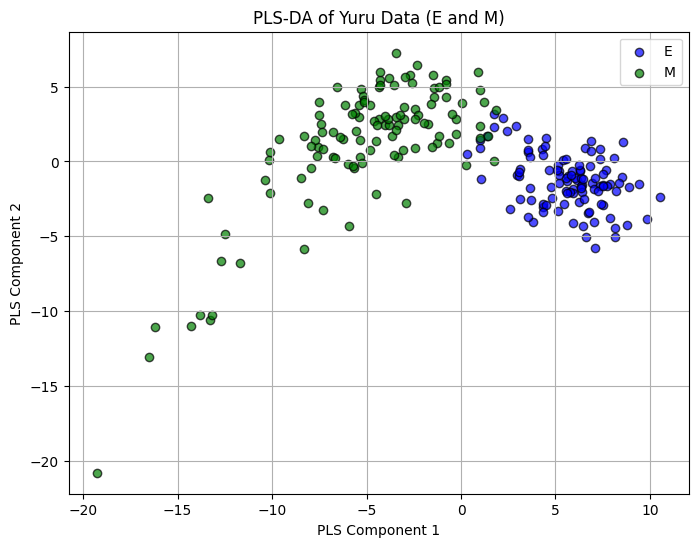

In [13]:
# plot the PLS-DA results
plt.figure(figsize=(8, 6))
plt.scatter(X_old_pls_da[y == 'E', 0], X_old_pls_da[y == 'E', 1], c='blue', label='E', alpha=0.7, edgecolor='k')
plt.scatter(X_old_pls_da[y == 'M', 0], X_old_pls_da[y == 'M', 1], c='green', label='M', alpha=0.7, edgecolor='k')
plt.title('PLS-DA of Yuru Data (E and M)')
plt.xlabel('PLS Component 1')
plt.ylabel('PLS Component 2')
plt.legend()
plt.grid(True)
plt.show()
# save plot
plt.savefig("Metrics/pls-da_on_old_data.png", format='png', bbox_inches='tight')
plt.close()

## Apply PLS-DA Space to New data

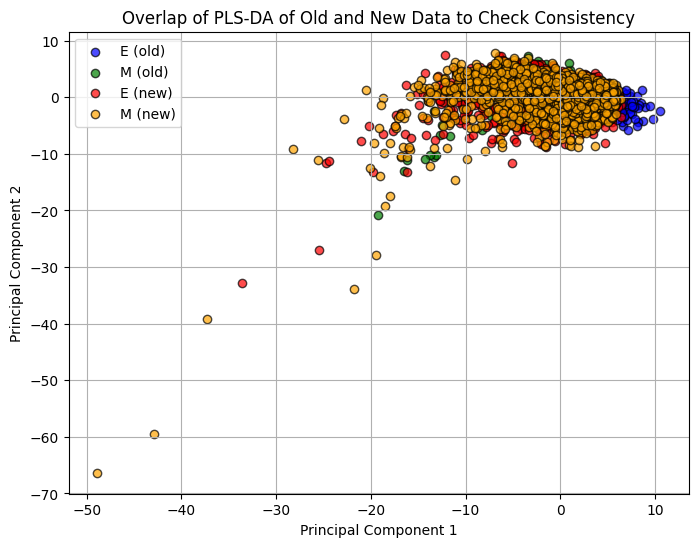

Plot Shows that the PCA space of New and Old data matches!


In [14]:
# y = annotation
y_new = final_combined_data2['Annotation'].values
y_new_encoded = le.fit_transform(y_new)

# Transform the old and new data using the fitted PLS-DA
X_new_pls_da = pls_da.transform(X_new_scaled)  # New data projected into the old PLS-DA space

# Compare the PLS-DA results of the old and new data
plt.figure(figsize=(8, 6))
plt.scatter(X_old_pls_da[y == 'E', 0], X_old_pls_da[y == 'E', 1], c='blue', label='E (old)', alpha=0.7, edgecolor='k')
plt.scatter(X_old_pls_da[y == 'M', 0], X_old_pls_da[y == 'M', 1], c='green', label='M (old)', alpha=0.7, edgecolor='k')
plt.scatter(X_new_pls_da[y_new == 'E', 0], X_new_pls_da[y_new == 'E', 1], c='red', label='E (new)', alpha=0.7, edgecolor='k')
plt.scatter(X_new_pls_da[y_new == 'M', 0], X_new_pls_da[y_new == 'M', 1], c='orange', label='M (new)', alpha=0.7, edgecolor='k')
plt.title('Overlap of PLS-DA of Old and New Data to Check Consistency')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()
# save plot
plt.savefig("Metrics/compare_pls-da_old_and_pls-da_new.png", format='png', bbox_inches='tight')
plt.close()

print('Plot Shows that the PCA space of New and Old data matches!')

# 3. Train Dicision Tree Model

## Fit Model

In [15]:
# Create a Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_old_scaled, y_old)

# Predict the test set
y_pred = dt.predict(X_old_scaled)

# Compute the confusion matrix
cm = confusion_matrix(y, y_pred, labels=['E', 'M'])

# Save the model
joblib.dump(dt, '111524dt_model.pkl')

['111524dt_model.pkl']

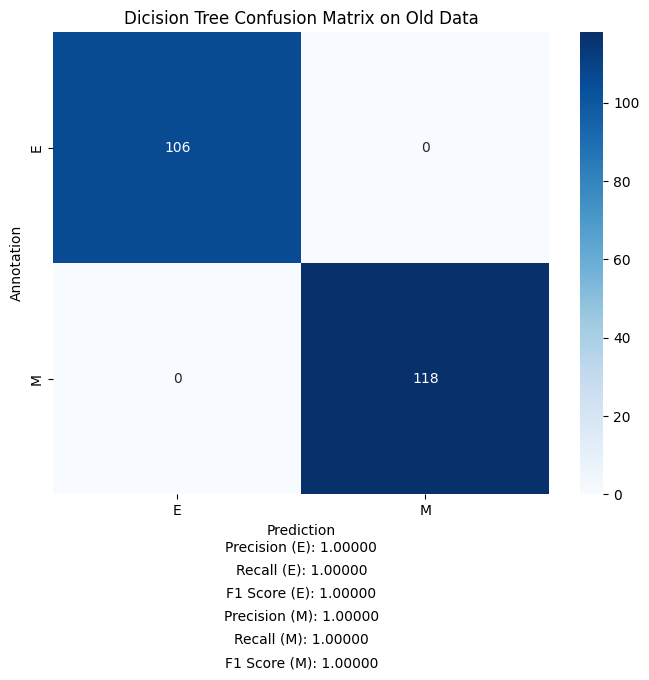

In [16]:
# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['E', 'M'], yticklabels=['E', 'M'])
plt.ylabel('Annotation')
plt.xlabel('Prediction')
plt.title('Dicision Tree Confusion Matrix on Old Data')

# Calculate precision, recall, and F1 score for each class
precision_e = precision_score(y, y_pred, pos_label='E', average='binary')
recall_e = recall_score(y, y_pred, pos_label='E', average='binary')
f1_e = f1_score(y, y_pred, pos_label='E', average='binary')

# Display metrics for 'E' state in the plot
plt.text(0.5, -0.1, f"Precision (E): {precision_e:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.15, f"Recall (E): {recall_e:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.2, f"F1 Score (E): {f1_e:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)

# Calculate metrics for 'M' state
precision_m = precision_score(y, y_pred, pos_label='M', average='binary')
recall_m = recall_score(y, y_pred, pos_label='M', average='binary')
f1_m = f1_score(y, y_pred, pos_label='M', average='binary')

# Display metrics for 'M' state in the plot
plt.text(0.5, -0.25, f"Precision (M): {precision_m:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.3, f"Recall (M): {recall_m:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.35, f"F1 Score (M): {f1_m:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)

# Save the confusion matrix plot
plt.savefig("Metrics/dt_on_old_data_confusion_matrix.png", format='png', bbox_inches='tight')
plt.show()
plt.close()  # Free memory by closing figure

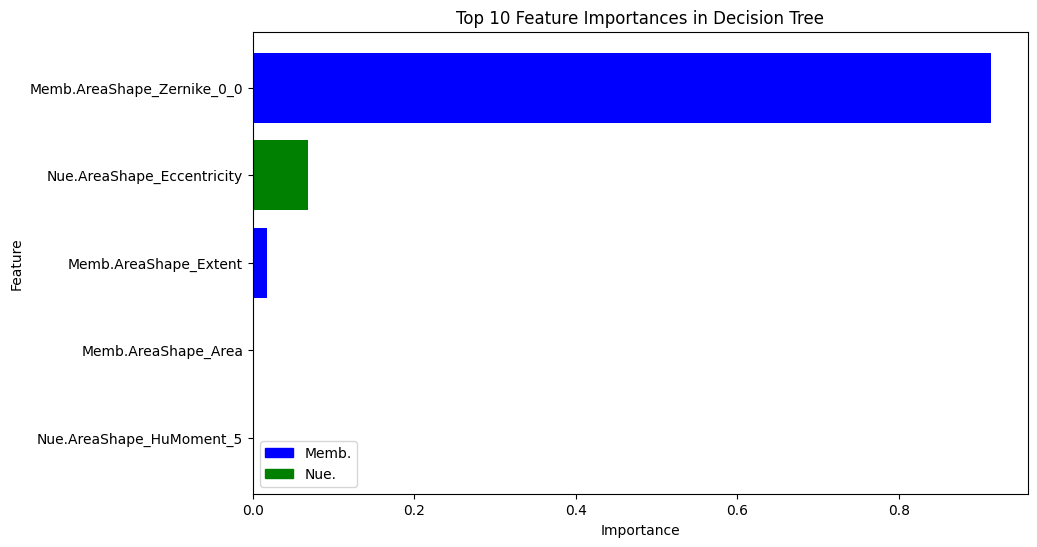

In [17]:
# Extract feature importances
feature_importances = dt.feature_importances_

# Create a DataFrame for better visualization
X_old_df = pd.DataFrame(X_old)
features_df = pd.DataFrame({
    'Feature': X_old_df.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance and keep only the top 10
top_features_df = features_df.sort_values(by='Importance', ascending=False).head(5)

# Define colors based on feature names
colors = ['blue' if 'Memb.' in feature else 'green' for feature in top_features_df['Feature']]

# Plot the top 10 feature importances with separate colors
plt.figure(figsize=(10, 6))
plt.barh(top_features_df['Feature'], top_features_df['Importance'], color=colors)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances in Decision Tree')
plt.gca().invert_yaxis()

# Create custom legend handles
blue_patch = mpatches.Patch(color='blue', label='Memb.')
green_patch = mpatches.Patch(color='green', label='Nue.')

# Add legend to the plot
plt.legend(handles=[blue_patch, green_patch])

plt.show()

# Save the feature importances plot
plt.savefig("Metrics/dt_on_old_data_feature_importances.png", format='png', bbox_inches='tight')
plt.close()  # Free memory by closing figure

## Apply Model to New Data

In [18]:
# Apply model to new data
y_new_pred = dt.predict(X_new_scaled)

# Compute the confusion matrix
cm_new = confusion_matrix(y_new, y_new_pred, labels=['E', 'M'])

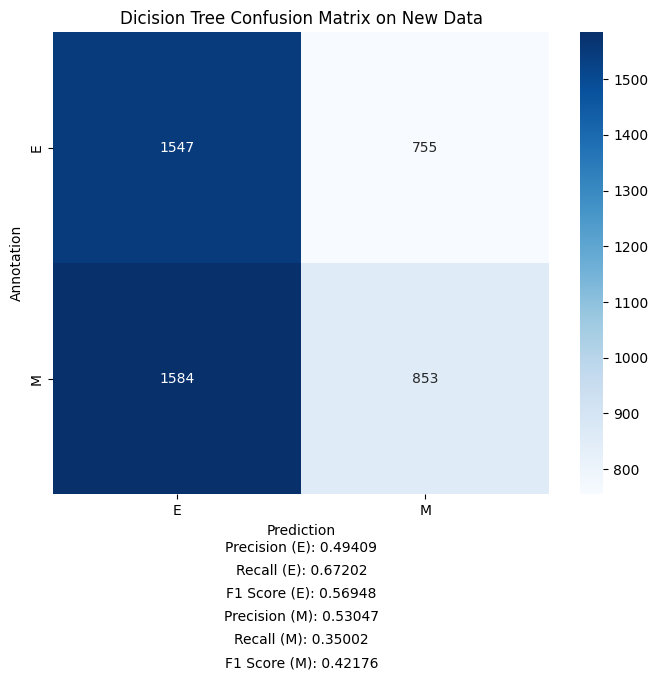

In [19]:
# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_new, annot=True, fmt='d', cmap='Blues', xticklabels=['E', 'M'], yticklabels=['E', 'M'])
plt.ylabel('Annotation')
plt.xlabel('Prediction')
plt.title('Dicision Tree Confusion Matrix on New Data')

# Calculate precision, recall, and F1 score for each class
precision_e = precision_score(y_new, y_new_pred, pos_label='E', average='binary')
recall_e = recall_score(y_new, y_new_pred, pos_label='E', average='binary')
f1_e = f1_score(y_new, y_new_pred, pos_label='E', average='binary')

# Display metrics for 'E' state in the plot
plt.text(0.5, -0.1, f"Precision (E): {precision_e:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.15, f"Recall (E): {recall_e:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.2, f"F1 Score (E): {f1_e:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)

# Calculate metrics for 'M' state
precision_m = precision_score(y_new, y_new_pred, pos_label='M', average='binary')
recall_m = recall_score(y_new, y_new_pred, pos_label='M', average='binary')
f1_m = f1_score(y_new, y_new_pred, pos_label='M', average='binary')

# Display metrics for 'M' state in the plot
plt.text(0.5, -0.25, f"Precision (M): {precision_m:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.3, f"Recall (M): {recall_m:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.35, f"F1 Score (M): {f1_m:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)

# Save the confusion matrix plot
plt.savefig("Metrics/dt_on_new_data_confusion_matrix.png", format='png', bbox_inches='tight')
plt.show()
plt.close()  # Free memory by closing figure

# 4. Train Logistic Regression Model

## Fit Model

In [20]:
# Create Logistic Regression model
lr = LogisticRegression(random_state=42)
lr.fit(X_old_scaled, y_old)

# Predict the test set
y_pred = lr.predict(X_old_scaled)

# Compute the confusion matrix
cm = confusion_matrix(y_old, y_pred, labels=['E', 'M'])

# Save the model
joblib.dump(lr, '111524lr_model.pkl')

['111524lr_model.pkl']

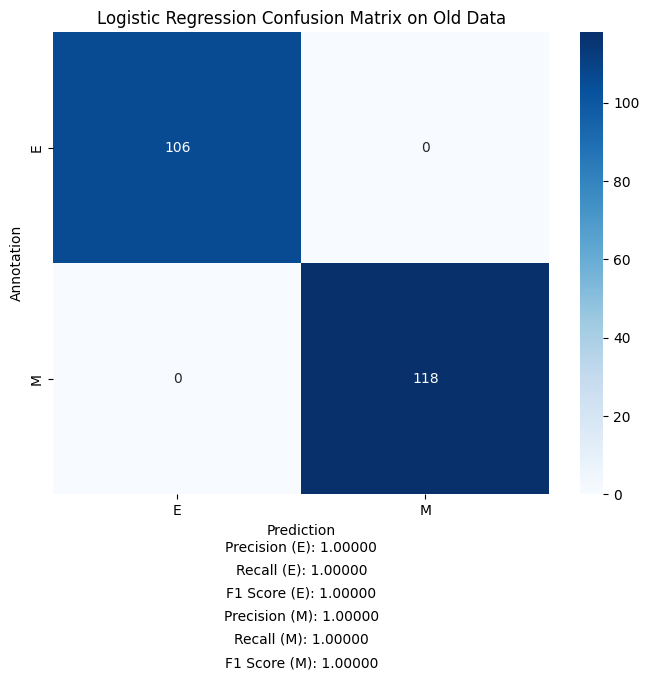

In [21]:
# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['E', 'M'], yticklabels=['E', 'M'])
plt.ylabel('Annotation')
plt.xlabel('Prediction')
plt.title('Logistic Regression Confusion Matrix on Old Data')

# Calculate precision, recall, and F1 score for each class
precision_e = precision_score(y_old, y_pred, pos_label='E', average='binary')
recall_e = recall_score(y_old, y_pred, pos_label='E', average='binary')
f1_e = f1_score(y_old, y_pred, pos_label='E', average='binary')

# Display metrics for 'E' state in the plot
plt.text(0.5, -0.1, f"Precision (E): {precision_e:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.15, f"Recall (E): {recall_e:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.2, f"F1 Score (E): {f1_e:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)

# Calculate metrics for 'M' state
precision_m = precision_score(y_old, y_pred, pos_label='M', average='binary')
recall_m = recall_score(y_old, y_pred, pos_label='M', average='binary')
f1_m = f1_score(y_old, y_pred, pos_label='M', average='binary')

# Display metrics for 'M' state in the plot
plt.text(0.5, -0.25, f"Precision (M): {precision_m:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.3, f"Recall (M): {recall_m:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.35, f"F1 Score (M): {f1_m:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)

# Save the confusion matrix plot
plt.savefig("Metrics/lr_on_old_data_confusion_matrix.png", format='png', bbox_inches='tight')
plt.show()
plt.close()  # Free memory by closing

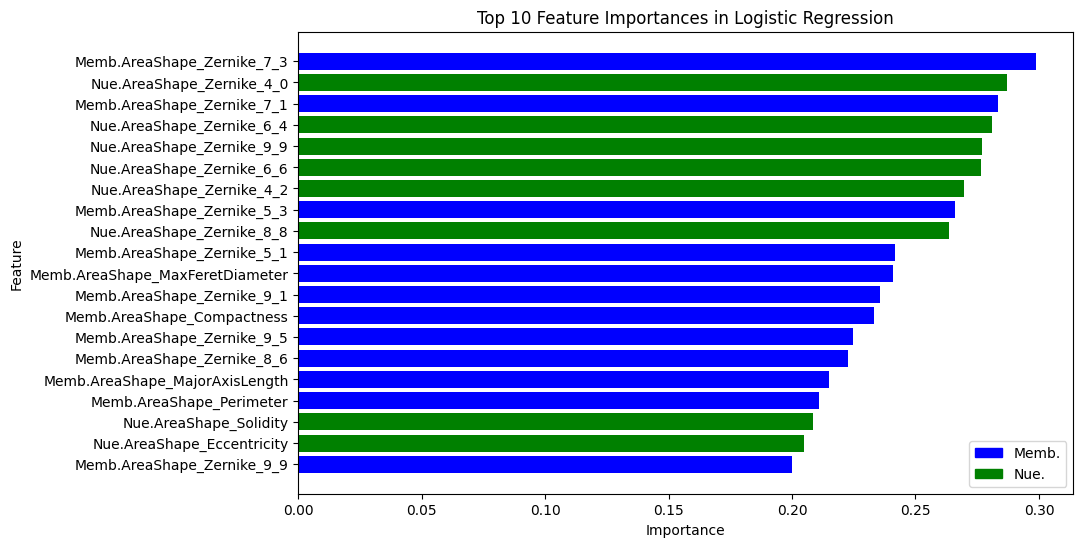

In [22]:
# Feature importances
feature_importances = lr.coef_[0]

# Create a DataFrame for better visualization
X_old_df = pd.DataFrame(X_old)
features_df = pd.DataFrame({
    'Feature': X_old_df.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance and keep only the top 10
top_features_df = features_df.sort_values(by='Importance', ascending=False).head(20)

# Define colors based on feature names
colors = ['blue' if 'Memb.' in feature else 'green' for feature in top_features_df['Feature']]
# Plot the top 10 feature importances with separate colors
plt.figure(figsize=(10, 6))
plt.barh(top_features_df['Feature'], top_features_df['Importance'], color=colors)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances in Logistic Regression')
plt.gca().invert_yaxis()

# Create custom legend handles
blue_patch = mpatches.Patch(color='blue', label='Memb.')
green_patch = mpatches.Patch(color='green', label='Nue.')

# Add legend to the plot
plt.legend(handles=[blue_patch, green_patch])

plt.show()

# Save the feature importances plot
plt.savefig("Metrics/lr_on_old_data_feature_importances.png", format='png', bbox_inches='tight')
plt.close()  # Free memory by closing figure

## Apply Model to New Data

In [23]:
# Apply model to new data
y_new_pred = lr.predict(X_new_scaled)

# Compute the confusion matrix
cm_new = confusion_matrix(y_new, y_new_pred, labels=['E', 'M'])

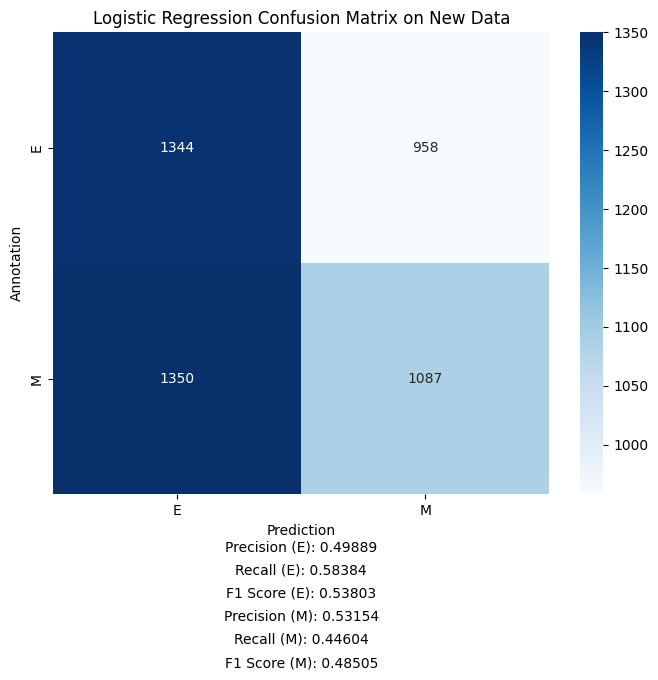

In [24]:
# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_new, annot=True, fmt='d', cmap='Blues', xticklabels=['E', 'M'], yticklabels=['E', 'M'])
plt.ylabel('Annotation')
plt.xlabel('Prediction')
plt.title('Logistic Regression Confusion Matrix on New Data')

# Calculate precision, recall, and F1 score for each class
precision_e = precision_score(y_new, y_new_pred, pos_label='E', average='binary')
recall_e = recall_score(y_new, y_new_pred, pos_label='E', average='binary')
f1_e = f1_score(y_new, y_new_pred, pos_label='E', average='binary')

# Display metrics for 'E' state in the plot
plt.text(0.5, -0.1, f"Precision (E): {precision_e:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.15, f"Recall (E): {recall_e:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.2, f"F1 Score (E): {f1_e:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)

# Calculate metrics for 'M' state
precision_m = precision_score(y_new, y_new_pred, pos_label='M', average='binary')
recall_m = recall_score(y_new, y_new_pred, pos_label='M', average='binary')
f1_m = f1_score(y_new, y_new_pred, pos_label='M', average='binary')

# Display metrics for 'M' state in the plot
plt.text(0.5, -0.25, f"Precision (M): {precision_m:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.3, f"Recall (M): {recall_m:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.35, f"F1 Score (M): {f1_m:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)

# Save the confusion matrix plot
plt.savefig("Metrics/lr_on_new_data_confusion_matrix.png", format='png', bbox_inches='tight')
plt.show()
plt.close()  # Free memory by closing

# 5. Try More Complex Model

In [25]:
# Create NN model
nn = Sequential()
nn.add(Dense(64, input_dim=X_old_scaled.shape[1], activation='relu'))
nn.add(Dense(32, activation='relu'))
nn.add(Dense(1, activation='sigmoid'))

# Compile the model
nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
nn.fit(X_old_scaled, y_old_encoded, epochs=50, batch_size=32, validation_split=0.2)

# Save the model
nn.save('111524nn_model.h5')

/home/tyoneyam/miniforge3/envs/jupyter_env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.7291 - loss: 0.5438 - val_accuracy: 0.6889 - val_loss: 0.5492
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9450 - loss: 0.2425 - val_accuracy: 0.8667 - val_loss: 0.3491
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9669 - loss: 0.1314 - val_accuracy: 0.9111 - val_loss: 0.2683
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9666 - loss: 0.0908 - val_accuracy: 0.9111 - val_loss: 0.2221
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9964 - loss: 0.0601 - val_accuracy: 0.9111 - val_loss: 0.1887
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0484 - val_accuracy: 0.9333 - val_loss: 0.1577
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0383 - val_accuracy: 0.9556 - val_loss: 0.1322
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0246 - val_accuracy: 0.9778 - val_loss: 0.1138
Ep

In [26]:
# Make prediction
y_pred = nn.predict(X_old_scaled)

# Compute the confusion matrix
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_old_encoded, y_pred)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


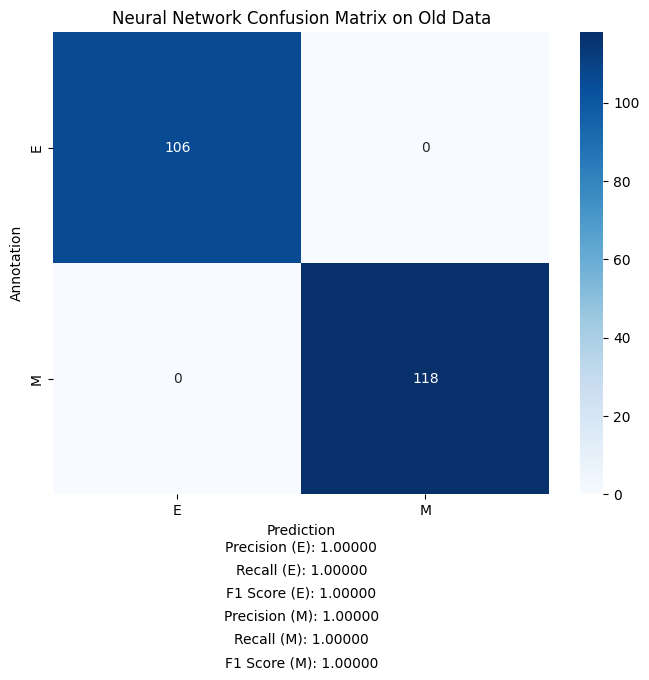

In [27]:
# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['E', 'M'], yticklabels=['E', 'M'])
plt.ylabel('Annotation')
plt.xlabel('Prediction')
plt.title('Neural Network Confusion Matrix on Old Data')

# Calculate precision, recall, and F1 score for each class
precision_e = precision_score(y_old_encoded, y_pred, pos_label=0, average='binary')
recall_e = recall_score(y_old_encoded, y_pred, pos_label=0, average='binary')
f1_e = f1_score(y_old_encoded, y_pred, pos_label=0, average='binary')

# Display metrics for 'E' state in the plot
plt.text(0.5, -0.1, f"Precision (E): {precision_e:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.15, f"Recall (E): {recall_e:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.2, f"F1 Score (E): {f1_e:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)

# Calculate metrics for 'M' state
precision_m = precision_score(y_old_encoded, y_pred, pos_label=1, average='binary')
recall_m = recall_score(y_old_encoded, y_pred, pos_label=1, average='binary')
f1_m = f1_score(y_old_encoded, y_pred, pos_label=1, average='binary')

# Display metrics for 'M' state in the plot
plt.text(0.5, -0.25, f"Precision (M): {precision_m:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.3, f"Recall (M): {recall_m:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.35, f"F1 Score (M): {f1_m:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)

# Save the confusion matrix plot
plt.savefig("Metrics/nn_on_old_data_confusion_matrix.png", format='png', bbox_inches='tight')
plt.show()
plt.close()  # Free memory by closing

## Apply NN Model to New Data

In [28]:
# Apply model to new data
y_new_pred = nn.predict(X_new_scaled)

# Compute the confusion matrix
y_new_pred = (y_new_pred > 0.5).astype(int)
cm_new = confusion_matrix(y_new_encoded, y_new_pred)

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


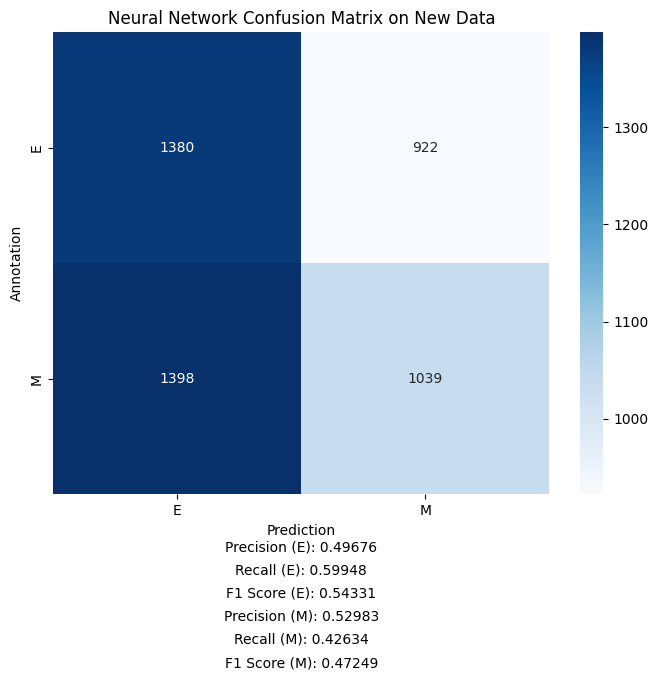

In [29]:
# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_new, annot=True, fmt='d', cmap='Blues', xticklabels=['E', 'M'], yticklabels=['E', 'M'])
plt.ylabel('Annotation')
plt.xlabel('Prediction')
plt.title('Neural Network Confusion Matrix on New Data')

# Calculate precision, recall, and F1 score for each class
precision_e = precision_score(y_new_encoded, y_new_pred, pos_label=0, average='binary')
recall_e = recall_score(y_new_encoded, y_new_pred, pos_label=0, average='binary')
f1_e = f1_score(y_new_encoded, y_new_pred, pos_label=0, average='binary')

# Display metrics for 'E' state in the plot
plt.text(0.5, -0.1, f"Precision (E): {precision_e:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.15, f"Recall (E): {recall_e:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.2, f"F1 Score (E): {f1_e:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)

# Calculate metrics for 'M' state
precision_m = precision_score(y_new_encoded, y_new_pred, pos_label=1, average='binary')
recall_m = recall_score(y_new_encoded, y_new_pred, pos_label=1, average='binary')
f1_m = f1_score(y_new_encoded, y_new_pred, pos_label=1, average='binary')

# Display metrics for 'M' state in the plot
plt.text(0.5, -0.25, f"Precision (M): {precision_m:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.3, f"Recall (M): {recall_m:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.35, f"F1 Score (M): {f1_m:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)

# Save the confusion matrix plot
plt.savefig("Metrics/nn_on_new_data_confusion_matrix.png", format='png', bbox_inches='tight')
plt.show()
plt.close()  # Free memory by closing

# 6. Linear Regression

## Fit Model

In [30]:
# Create Linear Regression model
lm = LinearRegression()
lm.fit(X_old_scaled, y_old_encoded)

# Make prediction
y_old_pred = lm.predict(X_old_scaled)
y_old_pred = np.round(y_old_pred)

# Compute the confusion matrix
cm = confusion_matrix(y_old_encoded, y_old_pred)

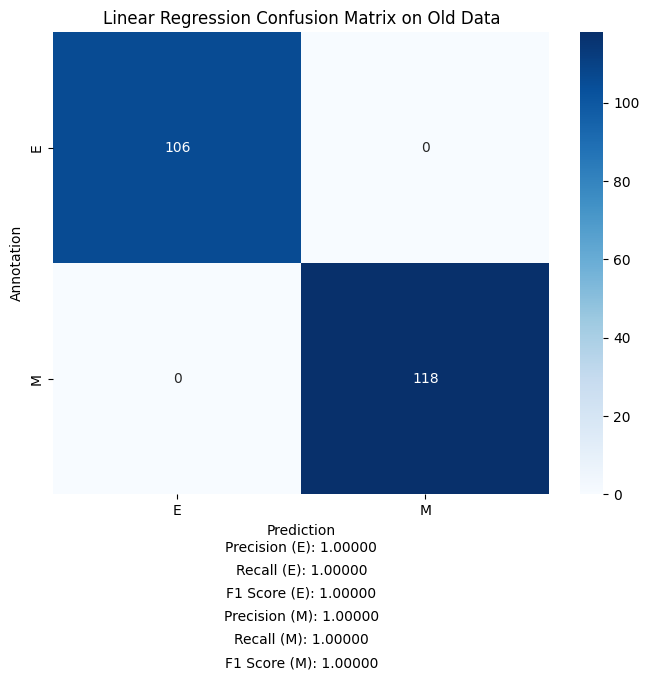

In [31]:
# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['E', 'M'], yticklabels=['E', 'M'])
plt.ylabel('Annotation')
plt.xlabel('Prediction')
plt.title('Linear Regression Confusion Matrix on Old Data')

# Calculate precision, recall, and F1 score for each class
precision_e = precision_score(y_old_encoded, y_old_pred, pos_label=0, average='binary')
recall_e = recall_score(y_old_encoded, y_old_pred, pos_label=0, average='binary')
f1_e = f1_score(y_old_encoded, y_old_pred, pos_label=0, average='binary')

# Display metrics for 'E' state in the plot
plt.text(0.5, -0.1, f"Precision (E): {precision_e:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.15, f"Recall (E): {recall_e:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.2, f"F1 Score (E): {f1_e:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)

# Calculate metrics for 'M' state
precision_m = precision_score(y_old_encoded, y_old_pred, pos_label=1, average='binary')
recall_m = recall_score(y_old_encoded, y_old_pred, pos_label=1, average='binary')
f1_m = f1_score(y_old_encoded, y_old_pred, pos_label=1, average='binary')

# Display metrics for 'M' state in the plot
plt.text(0.5, -0.25, f"Precision (M): {precision_m:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.3, f"Recall (M): {recall_m:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.35, f"F1 Score (M): {f1_m:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)

# Save the confusion matrix plot
plt.savefig("Metrics/lm_on_old_data_confusion_matrix.png", format='png', bbox_inches='tight')
plt.show()
plt.close()  # Free memory by closing

## Apply Model to New Data

In [32]:
# Apply model to new data
y_new_pred = lm.predict(X_new_scaled)

# Explicitly make binary predictions
y_new_pred_binary = (y_new_pred >= 0.5).astype(int)

# Print unique values in y_new_pred_binary
print('Unique values in y_new_pred_binary:', np.unique(y_new_pred_binary))

# Print whether y_new_pred_binary is multi-class or binary
print('y_new_pred_binary is multi-class' if len(np.unique(y_new_pred_binary)) > 2 else 'y_new_pred_binary is binary')

# Compute the confusion matrix
cm_new = confusion_matrix(y_new_encoded, y_new_pred_binary)

Unique values in y_new_pred_binary: [0 1]
y_new_pred_binary is binary


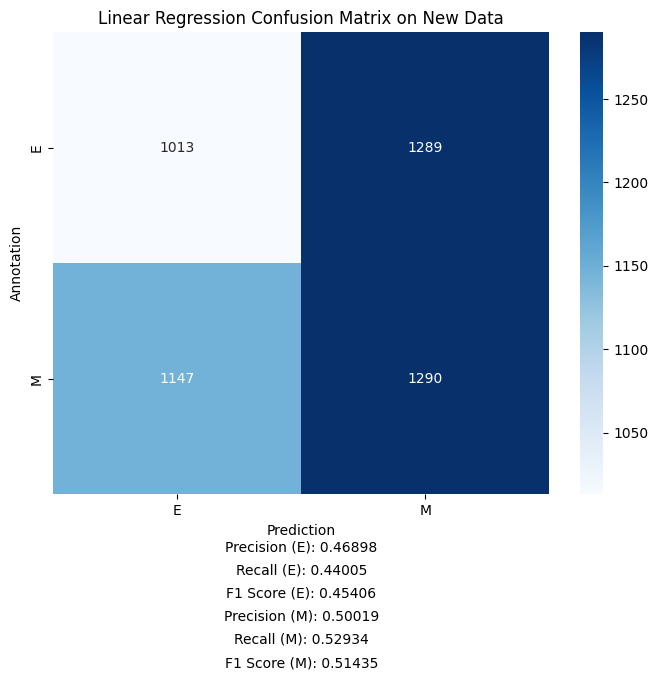

In [33]:
# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_new, annot=True, fmt='d', cmap='Blues', xticklabels=['E', 'M'], yticklabels=['E', 'M'])
plt.ylabel('Annotation')
plt.xlabel('Prediction')
plt.title('Linear Regression Confusion Matrix on New Data')

# Calculate precision, recall, and F1 score for each class
precision_e = precision_score(y_new_encoded, y_new_pred_binary, pos_label=0, average='binary')
recall_e = recall_score(y_new_encoded, y_new_pred_binary, pos_label=0, average='binary')
f1_e = f1_score(y_new_encoded, y_new_pred_binary, pos_label=0, average='binary')

# Display metrics for 'E' state in the plot
plt.text(0.5, -0.1, f"Precision (E): {precision_e:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.15, f"Recall (E): {recall_e:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.2, f"F1 Score (E): {f1_e:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)

# Calculate metrics for 'M' state
precision_m = precision_score(y_new_encoded, y_new_pred_binary, pos_label=1, average='binary')
recall_m = recall_score(y_new_encoded, y_new_pred_binary, pos_label=1, average='binary')
f1_m = f1_score(y_new_encoded, y_new_pred_binary, pos_label=1, average='binary')

# Display metrics for 'M' state in the plot
plt.text(0.5, -0.25, f"Precision (M): {precision_m:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.3, f"Recall (M): {recall_m:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.35, f"F1 Score (M): {f1_m:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)

# Save the confusion matrix plot
plt.savefig("Metrics/lm_on_new_data_confusion_matrix.png", format='png', bbox_inches='tight')
plt.show()
plt.close()  # Free memory by closing

# Normalize Data

Normalize since the New data seems to have very different patterns from the Old data

## Method 1

0 - Mean: 1.9825411154020654e-16, Std Dev: 1.0


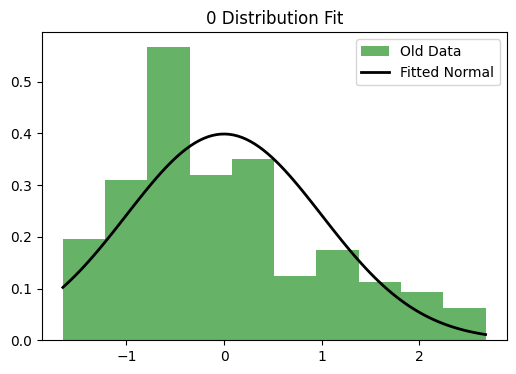

ValueError: supplied range of [-1.7837109112401046, inf] is not finite

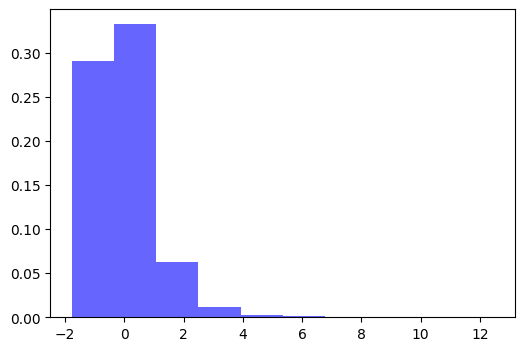

In [34]:
# Normalize old data

# Fit each feature to a normal distribution and transform the new data
X_old_scaled_df = pd.DataFrame(X_old_scaled)
X_new_scaled_df = pd.DataFrame(X_new_scaled)
X_new_normalized_1 = pd.DataFrame(X_new_scaled)
for feature in X_old_scaled_df.columns:
    # Estimate parameters of the normal distribution
    mu, sigma = norm.fit(X_old_scaled_df[feature])
    print(f"{feature} - Mean: {mu}, Std Dev: {sigma}")

    # plot only if first 5 features
    if feature in X_old_scaled_df.columns[:5]:
        # Plot distribution of the old data
        plt.figure(figsize=(6, 4))
        plt.hist(X_old_scaled_df[feature], bins=10, density=True, alpha=0.6, color='g', label="Old Data")
        # Overlay the fitted distribution
        x = np.linspace(X_old_scaled_df[feature].min(), X_old_scaled_df[feature].max(), 100)
        pdf = norm.pdf(x, mu, sigma)
        plt.plot(x, pdf, 'k', linewidth=2, label="Fitted Normal")
        plt.title(f"{feature} Distribution Fit")
        plt.legend()
        plt.show()
        
    # Transform new data to match this distribution
    X_new_normalized_1[feature] = (X_new_normalized_1[feature] - mu) / sigma  # Standardize
    X_new_normalized_1[feature] = norm.ppf(norm.cdf(X_new_normalized_1[feature], loc=mu, scale=sigma), loc=mu, scale=sigma)  # Map to fit distribution

    # Also plot normalized new data versus original new data
    if feature in X_old_scaled_df.columns[:5]:
        plt.figure(figsize=(6, 4))
        plt.hist(X_new_scaled_df[feature], bins=10, density=True, alpha=0.6, color='b', label="New Data")
        plt.hist(X_new_normalized_1[feature], bins=10, density=True, alpha=0.6, color='r', label="Normalized New Data")
        plt.title(f"{feature} Normalization")
        plt.legend()
        plt.show()

print("Transformed New Data:\n", X_new_normalized_1)

## Method 2

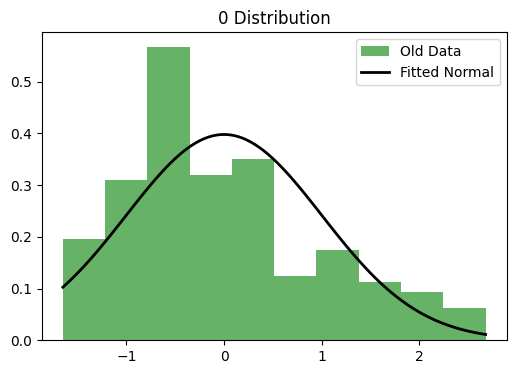

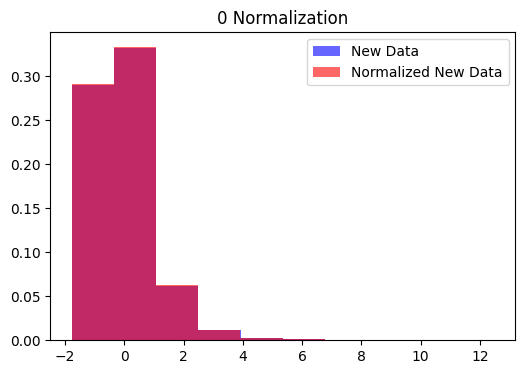

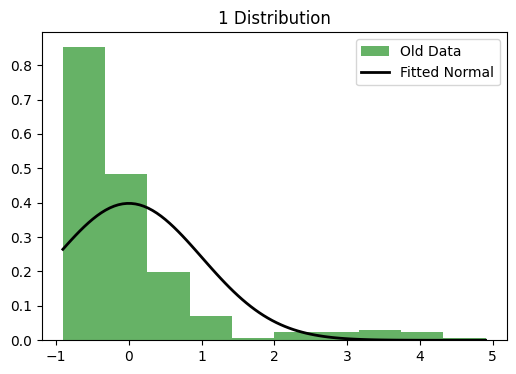

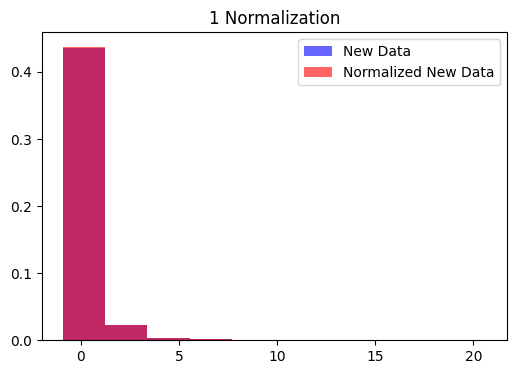

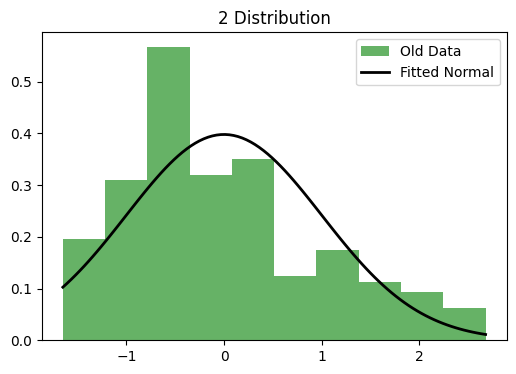

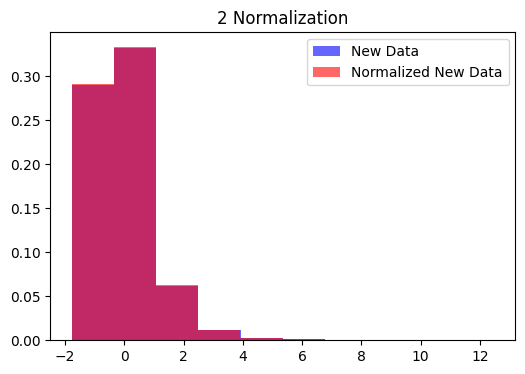

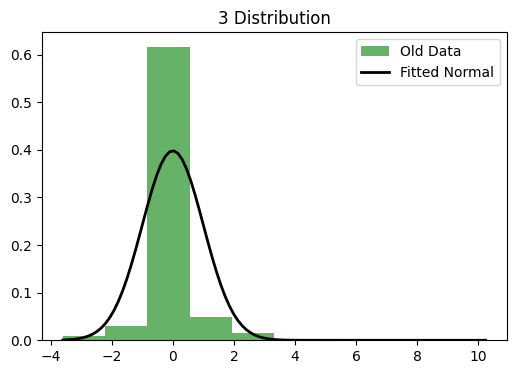

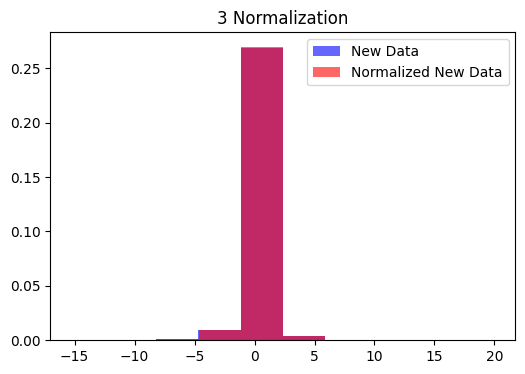

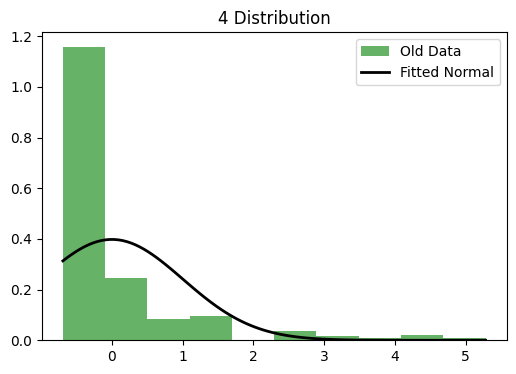

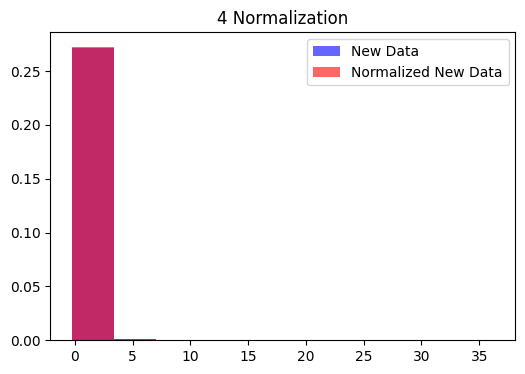

Old Data Normalized:
           0         1         2         3         4         5         6    \
0   -0.385959 -0.235749 -0.385959  0.001799 -0.588021 -0.060925  0.780619   
1   -0.385959 -0.235749 -0.385959  0.001799 -0.588021 -0.060925  0.780619   
2    0.007475 -0.166861  0.007475  0.074503 -0.661995 -0.058806  1.837700   
3    0.007475 -0.166861  0.007475  0.074503 -0.661995 -0.058806  1.837700   
4    0.594202  0.072847  0.594202 -1.891167  3.320114  0.114930  0.134106   
..        ...       ...       ...       ...       ...       ...       ...   
219  0.107545  0.055138  0.107545 -0.384153 -0.441943 -0.100159 -0.480286   
220 -0.654568 -0.188892 -0.654568 -0.371553 -0.425871 -0.049182 -0.015229   
221  1.355788  1.112599  1.355788  0.720906  1.114247  0.260053 -0.046357   
222  1.355788  1.112599  1.355788  0.720906  1.114247  0.260053 -0.046357   
223 -0.933711 -0.584677 -0.933711 -0.536619 -0.384666 -0.050721 -0.171338   

          7         8         9    ...       189     

In [35]:
# Normalization Method 2

# Initialize normalized dataframes
X_old_normalized_2 = pd.DataFrame(X_old_scaled)
X_new_normalized_2 = pd.DataFrame(X_new_scaled)
# Normalize feature-wise
for feature in X_old_normalized_2.columns:
    # Compute mean and std for the feature in old data
    mean = X_old_normalized_2[feature].mean()
    std = X_old_normalized_2[feature].std()
    
    # Plot if first 5 features
    if feature in X_old_normalized_2.columns[:5]:
        plt.figure(figsize=(6, 4))
        plt.hist(X_old_normalized_2[feature], bins=10, density=True, alpha=0.6, color='g', label="Old Data")
        # Overlay the fitted distribution
        x = np.linspace(X_old_normalized_2[feature].min(), X_old_normalized_2[feature].max(), 100)
        pdf = norm.pdf(x, mean, std)
        plt.plot(x, pdf, 'k', linewidth=2, label="Fitted Normal")
        plt.title(f"{feature} Distribution")
        plt.legend()
        plt.show()

    # Normalize the feature in old and new data
    X_old_normalized_2[feature] = (X_old_normalized_2[feature] - mean) / std
    X_new_normalized_2[feature] = (X_new_normalized_2[feature] - mean) / std

    # Plot normalized new data versus original new data
    if feature in X_old_normalized_2.columns[:5]:
        plt.figure(figsize=(6, 4))
        plt.hist(X_new_scaled_df[feature], bins=10, density=True, alpha=0.6, color='b', label="New Data")
        plt.hist(X_new_normalized_2[feature], bins=10, density=True, alpha=0.6, color='r', label="Normalized New Data")
        plt.title(f"{feature} Normalization")
        plt.legend()
        plt.show()
        
# Print results
print('Old Data Normalized:\n', X_old_normalized_2)
print('New Data Normalized:\n', X_new_normalized_2)

# PCA on Normalized Data

In [68]:
# Create PCA model
pca = PCA(n_components=2)
X_old_normalized_1_pca = pca.fit_transform(X_old_normalized_1)

# X_pca would have a shape of (n_samples, n_components)
print("n_samples = ", X_old_normalized_1.shape[0])
print("X_pca shape: ", X_old_normalized_1_pca.shape)

# y = annotation
y = final_combined_data1['Annotation'].values

# Print out explained variance ratio
print("Explained variance ratio: ", pca.explained_variance_ratio_)

n_samples =  224
X_pca shape:  (224, 2)
Explained variance ratio:  [0.21675604 0.09169565]


In [69]:
# Access PC1 loadings
pc1_loadings = pca.components_[0]
# Combine with feature names for readability
X_old_df = pd.DataFrame(X_old)
pc1_features = pd.DataFrame({'Feature': X_old_df.columns, 'PC1 Loading': pc1_loadings})
pc1_features = pc1_features.sort_values(by='PC1 Loading', ascending=False)
# Print
print(pc1_features)
# Save
pc1_features.to_csv('111524pc1_features.csv', index=False)

                             Feature  PC1 Loading
35   Memb.AreaShape_MaxFeretDiameter     0.136378
34    Memb.AreaShape_MajorAxisLength     0.135164
14        Memb.AreaShape_Compactness     0.129918
135   Nue.AreaShape_MaxFeretDiameter     0.129114
134    Nue.AreaShape_MajorAxisLength     0.128574
..                               ...          ...
69        Memb.AreaShape_Zernike_0_0    -0.119915
120         Nue.AreaShape_FormFactor    -0.120521
169        Nue.AreaShape_Zernike_0_0    -0.123130
20         Memb.AreaShape_FormFactor    -0.123387
71        Memb.AreaShape_Zernike_2_0    -0.125332

[199 rows x 2 columns]


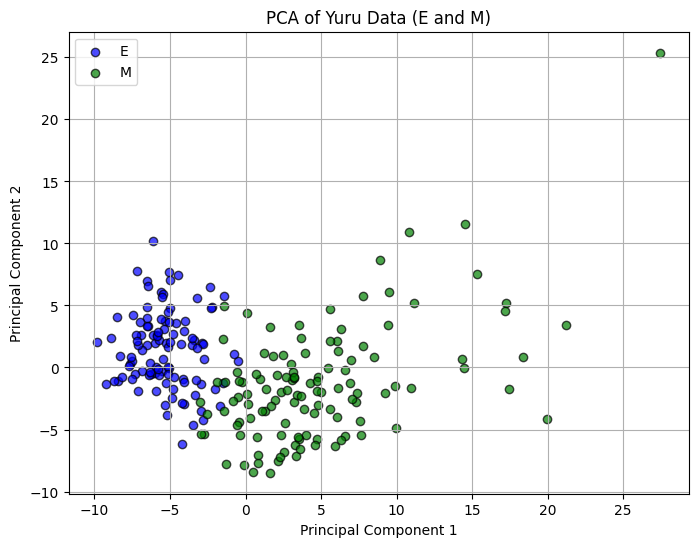

In [70]:
# plot the PCA results
plt.figure(figsize=(8, 6))
plt.scatter(X_old_normalized_1_pca[y == 'E', 0], X_old_normalized_1_pca[y == 'E', 1], c='blue', label='E', alpha=0.7, edgecolor='k')
plt.scatter(X_old_normalized_1_pca[y == 'M', 0], X_old_normalized_1_pca[y == 'M', 1], c='green', label='M', alpha=0.7, edgecolor='k')
plt.title('PCA of Yuru Data (E and M)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()
# save plot
plt.savefig("Metrics/pca_on_data1.png", format='png', bbox_inches='tight')
plt.close()

X_new_normalized_1 contains nan: True
Columns containing nan values: [18, 118]


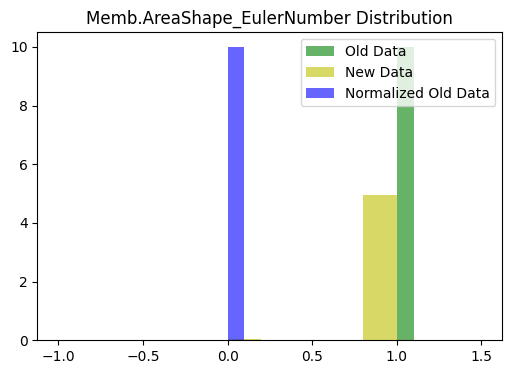

In [87]:
# does X_new_normalized_1 contain nan
print('X_new_normalized_1 contains nan:', X_new_normalized_1.isnull().values.any())

# show column names containing nan values
print('Columns containing nan values:', X_new_normalized_1.columns[X_new_normalized_1.isnull().all()].tolist())

# Plot 'Memb.AreaShape_EulerNumber' distribution before and after normalization for old data
plt.figure(figsize=(6, 4))
plt.hist(X_old['Memb.AreaShape_EulerNumber'], bins=10, density=True, alpha=0.6, color='g', label="Old Data")
plt.hist(X_new['Memb.AreaShape_EulerNumber'], bins=10, density=True, alpha=0.6, color='y', label="New Data")
plt.hist(X_old_normalized_1.iloc[:, 18], bins=10, density=True, alpha=0.6, color='b', label="Normalized Old Data")
plt.title('Memb.AreaShape_EulerNumber Distribution')
plt.legend()
plt.show()

In [71]:
# Transform the old and new data using the fitted PCA
X_new_normalized_1_pca = pca.transform(X_new_normalized_1)  # New data projected into the old PCA space

# y = annotation
y_new = final_combined_data2['Annotation'].values

# Compare the PCA results of the old and new data
plt.figure(figsize=(8, 6))
plt.scatter(X_old_normalized_1_pca[y == 'E', 0], X_old_normalized_1_pca[y == 'E', 1], c='blue', label='E (old)', alpha=0.7, edgecolor='k')
plt.scatter(X_old_normalized_1_pca[y == 'M', 0], X_old_normalized_1_pca[y == 'M', 1], c='green', label='M (old)', alpha=0.7, edgecolor='k')
plt.scatter(X_new_normalized_1_pca[y_new == 'E', 0], X_new_normalized_1_pca[y_new == 'E', 1], c='red', label='E (new)', alpha=0.7, edgecolor='k')
plt.scatter(X_new_normalized_1_pca[y_new == 'M', 0], X_new_normalized_1_pca[y_new == 'M', 1], c='orange', label='M (new)', alpha=0.7, edgecolor='k')
plt.title('Overlap of PCA of Old and New Data to Check Consistency')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()
# save plot
plt.savefig("Metrics/compare_pca_old_and_pca_new.png", format='png', bbox_inches='tight')
plt.close()

print('Plot Shows that the PCA space of New and Old data matches!')

/home/tyoneyam/miniforge3/envs/jupyter_env/lib/python3.12/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values